# Pulling rivers from OpenStreetMap (OSM)

In [2]:
import OSMPythonTools
import OSMPythonTools.api
import OSMPythonTools.overpass
from OSMPythonTools.overpass import overpassQueryBuilder
import geopandas
import shapely
import pathlib
import numpy
import matplotlib.pyplot

## Waikanae region of interest
OSM uses Latitudes and Longitudes (EPSG:4326) as its coordinate system.

In [6]:
def bbox_from_points(x0, y0, x1, y1) -> geopandas.GeoDataFrame:
    bbox_nztm2000 = geopandas.GeoDataFrame(
        geometry=[shapely.geometry.Polygon([[x0, y0],
                                            [x1, y0],
                                            [x1, y1],
                                            [x0, y1]])],
                                           crs='EPSG:2193')
    return bbox_nztm2000

In [8]:
def query_from_bbox(bbox_nztm2000) -> tuple:
    print(f"Is x1/y1 greater than x0/y0? dx={x1-x0}, and dy={y1-y0}")

    bbox_lat_long = bbox_nztm2000.to_crs('EPSG:4326')
    query = overpassQueryBuilder(bbox=[bbox_lat_long.bounds.miny[0],
                                       bbox_lat_long.bounds.minx[0],
                                       bbox_lat_long.bounds.maxy[0],
                                       bbox_lat_long.bounds.maxx[0]], 
                                 elementType='way', selector='waterway',
                                 out='body', includeGeometry=True)
    print(query)
    overpass = OSMPythonTools.overpass.Overpass()
    rivers = overpass.query(query)
    return rivers, bbox_nztm2000

In [9]:
def drains_from_rivers(rivers):
    element_dict = {
        'geometry': [],
        'OSM_id': [],
        'waterway': [],
        'tunnel': [],
    }

    for element in rivers.elements():
        element_dict['geometry'].append(element.geometry())
        element_dict['OSM_id'].append(element.id())
        element_dict['waterway'].append(element.tags()['waterway'])
        element_dict['tunnel'].append('tunnel' in element.tags().keys())
    drains_df = geopandas.GeoDataFrame(element_dict, crs='EPSG:4326').to_crs('EPSG:2193')
    return drains_df

# A query that works

Is x1/y1 greater than x0/y0? dx=9217, and dy=7711
(way[waterway](-40.91160630219117,174.99364670676297,-40.840243712602486,175.10510715718377);); out body geom;


<AxesSubplot:>

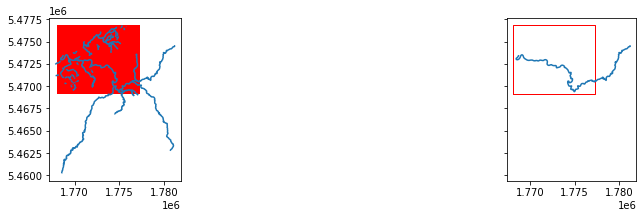

In [11]:
x0 = 1768073
y0 = 5469138
x1 = 1777290
y1 = 5476849 # origional
bbox_original = bbox_from_points(x0=x0, y0=y0, x1=x1, y1=y1)
rivers, bbox = query_from_bbox(bbox_original)
drains = drains_from_rivers(rivers)
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,3))
bbox.plot(ax=axs[0], color='r')
drains.plot(ax=axs[0])
bbox.plot(ax=axs[0], color='r')
drains[drains['OSM_id']==132793862].plot(ax=axs[1])
bbox.plot(ax=axs[1], facecolor="none", edgecolor='r')

In [13]:
drains[drains['waterway']=='river']

,geometry,OSM_id,waterway,tunnel
0,"LINESTRING (1781260.295 5474518.532, 1781201.8...",132793862,river,False
68,"LINESTRING (1780709.784 5462755.267, 1780747.0...",609119102,river,False
69,"LINESTRING (1777120.623 5468984.873, 1777058.1...",609119113,river,False


In [12]:
overpass = OSMPythonTools.overpass.Overpass()
rivers = overpass.query("(way[waterway](132793862);); out body geom;")

[overpass] downloading data: [timeout:25][out:json];(way[waterway](132793862);); out body geom;


In [15]:
rivers.elements()

# Cut OSM river to length
Load the smoothed REC channel
Load the selected OSM
Cut the OSM to the REC length

In [18]:
import OSMPythonTools.overpass
import geopandas
import shapely
osm_id = 132793862
overpass = OSMPythonTools.overpass.Overpass(); 
osm_channel = overpass.query(f"(way[waterway]({osm_id});); out body geom;")
osm_channel = osm_channel.elements()[0]
osm_channel = geopandas.GeoDataFrame(
    {
        "geometry": [osm_channel.geometry()],
        "OSM_id": [osm_channel.id()],
        "waterway": [osm_channel.tags()["waterway"]],
    }, crs='EPSG:4326').to_crs('EPSG:2193')

In [19]:
rec_smoothed_path = r"C:\Users\pearsonra\Documents\data\Waikanae\caches\Wellington_2013\test_catchment\rec_channel_129000000_smoothed.geojson"
smoothed_rec_channel = geopandas.read_file(rec_smoothed_path)

<AxesSubplot:>

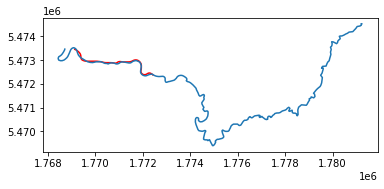

In [38]:
f, ax = matplotlib.pyplot.subplots()
smoothed_rec_channel.plot(ax=ax, color='r')
osm_channel.plot(ax=ax)

In [116]:
rec_extents = smoothed_rec_channel.boundary.explode(index_parts=False)
rec_start, rec_end = (rec_extents.iloc[0], rec_extents.iloc[1])

In [127]:
end_split_length = float(osm_channel.project(rec_end))
start_split_length = float(osm_channel.project(rec_start))

In [128]:
# Work out if the osm_channel is defined from or to the ocean - from ocean index=, to ocean index=1
osm_from_ocean = True if start_split_length < end_split_length else False

In [133]:
end_split_point = osm_channel.interpolate(end_split_length)
start_split_point = osm_channel.interpolate(start_split_length)

<AxesSubplot:>

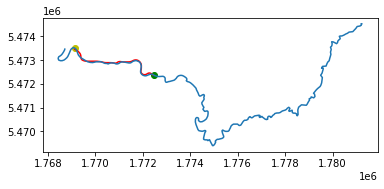

In [139]:
f, ax = matplotlib.pyplot.subplots()
smoothed_rec_channel.plot(ax=ax, color='r')
osm_channel.plot(ax=ax)
end_split_point.plot(ax=ax, color='g')
start_split_point.plot(ax=ax, color='y')

In [140]:
osm_channel_with_point = shapely.ops.snap(osm_channel.loc[0].geometry, end_split_point.loc[0], tolerance=0.1)
osm_channel_with_point = shapely.ops.snap(osm_channel_with_point, start_split_point.loc[0], tolerance=0.1)

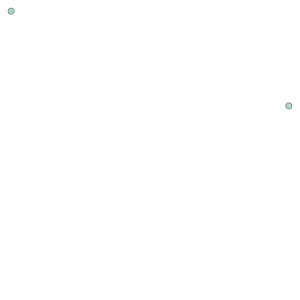

In [143]:
shapely.geometry.MultiPoint([end_split_point.loc[0], start_split_point.loc[0]])

In [146]:
lines = shapely.ops.split(osm_channel_with_point, shapely.geometry.MultiPoint([start_split_point.loc[0], end_split_point.loc[0]]))

In [147]:
len(lines.geoms)

3

In [148]:
osm_channel_cut = geopandas.GeoSeries(lines.geoms, crs="EPSG:2193")

<AxesSubplot:>

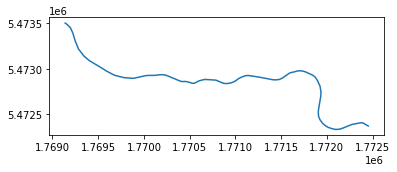

In [151]:
osm_channel_cut.iloc[1:2].plot()

In [125]:
osm_channel_cut = osm_channel_cut.iloc[:1] if osm_from_ocean else osm_channel_cut.iloc[1:]

<AxesSubplot:>

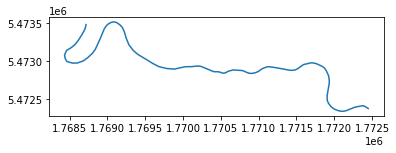

In [126]:
osm_channel_cut.plot()